<a href="https://www.kaggle.com/code/dityanugroho/introvert-extrovert-classifier-stacking?scriptVersionId=248648578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Load Dataset

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

In [3]:
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [4]:
le_encoder = LabelEncoder()
df_train['Personality_encoded'] = le_encoder.fit_transform(df_train['Personality'])

In [5]:
fear_encoder = LabelEncoder()
drained_encoder = LabelEncoder()

df_train['Stage_fear'] = fear_encoder.fit_transform(df_train['Stage_fear'])
df_train['Drained_after_socializing'] = drained_encoder.fit_transform(df_train['Drained_after_socializing'])

df_test['Stage_fear'] = fear_encoder.transform(df_test['Stage_fear'])
df_test['Drained_after_socializing'] = drained_encoder.transform(df_test['Drained_after_socializing'])

# 2. EDA

In [6]:
print(f'Train Shape: {df_train.shape}')
print(f'Test Shape: {df_test.shape}')

Train Shape: (18524, 9)
Test Shape: (6175, 7)


In [7]:
train_columns = df_train.columns
train_columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality', 'Personality_encoded'],
      dtype='object')

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 18524 non-null  int64  
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  18524 non-null  int64  
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
 8   Personality_encoded        18524 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 1.3+ MB


In [9]:
df_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Personality_encoded
0,0.0,0,6.0,4.0,0,15.0,5.0,Extrovert,0
1,1.0,0,7.0,3.0,0,10.0,8.0,Extrovert,0
2,6.0,1,1.0,0.0,2,3.0,0.0,Introvert,1
3,3.0,0,7.0,3.0,0,11.0,5.0,Extrovert,0
4,1.0,0,4.0,4.0,0,13.0,NaN,Extrovert,0


In [10]:
def nan_info(df):
    df_total_rows = len(df)
    df_nan_count = df.isna().sum()
    df_nan_percentage = (df_nan_count / df_total_rows) * 100
    df_nan_info = pd.DataFrame({
        'nan_count': df_nan_count,
        'nan_percentage': df_nan_percentage,
        'below < 5%': df_nan_percentage < 5,
    }).sort_values(by='nan_percentage', ascending=True)

    return df_nan_info

In [11]:
nan_info(df_train)

,nan_count,nan_percentage,below < 5%
Stage_fear,0,0.000000,True
Drained_after_socializing,0,0.000000,True
Personality,0,0.000000,True
Personality_encoded,0,0.000000,True
Friends_circle_size,1054,5.689916,False
Social_event_attendance,1180,6.370114,False
Time_spent_Alone,1190,6.424098,False
Post_frequency,1264,6.823580,False
Going_outside,1466,7.914057,False


In [12]:
def inf_info(df):
    df_number = df.select_dtypes(include=[np.number])

    return np.isinf(df_number).sum()

In [13]:
inf_info(df_train)

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality_encoded          0
dtype: int64

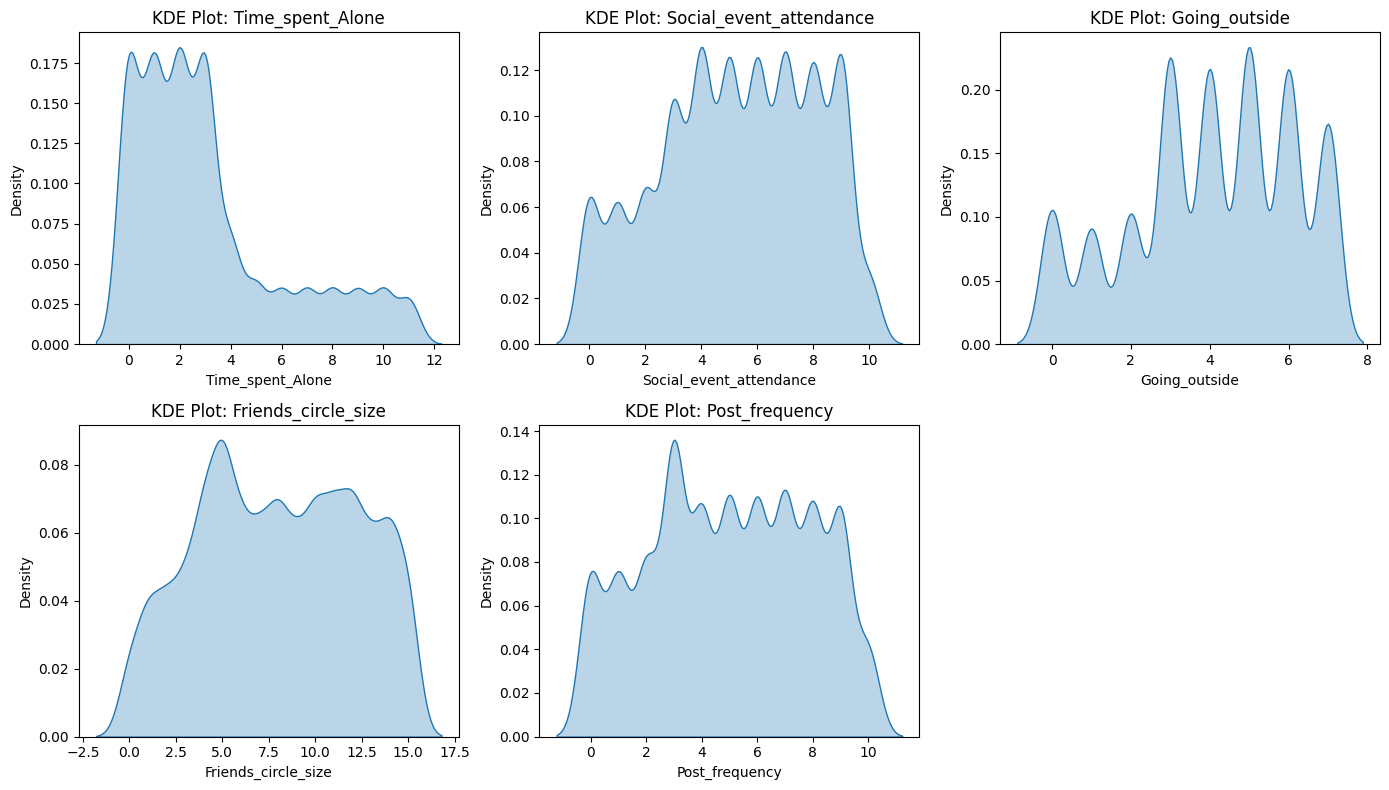

In [14]:
num_cols = [
    'Time_spent_Alone',
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

df_train[num_cols] = df_train[num_cols].replace([np.inf, -np.inf], np.nan)

n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(
        df_train[col].dropna(),
        ax=axes[i],
        fill=True,
        alpha=0.3
    )
    axes[i].set_title(f'KDE Plot: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Figure size 1400x400 with 0 Axes>

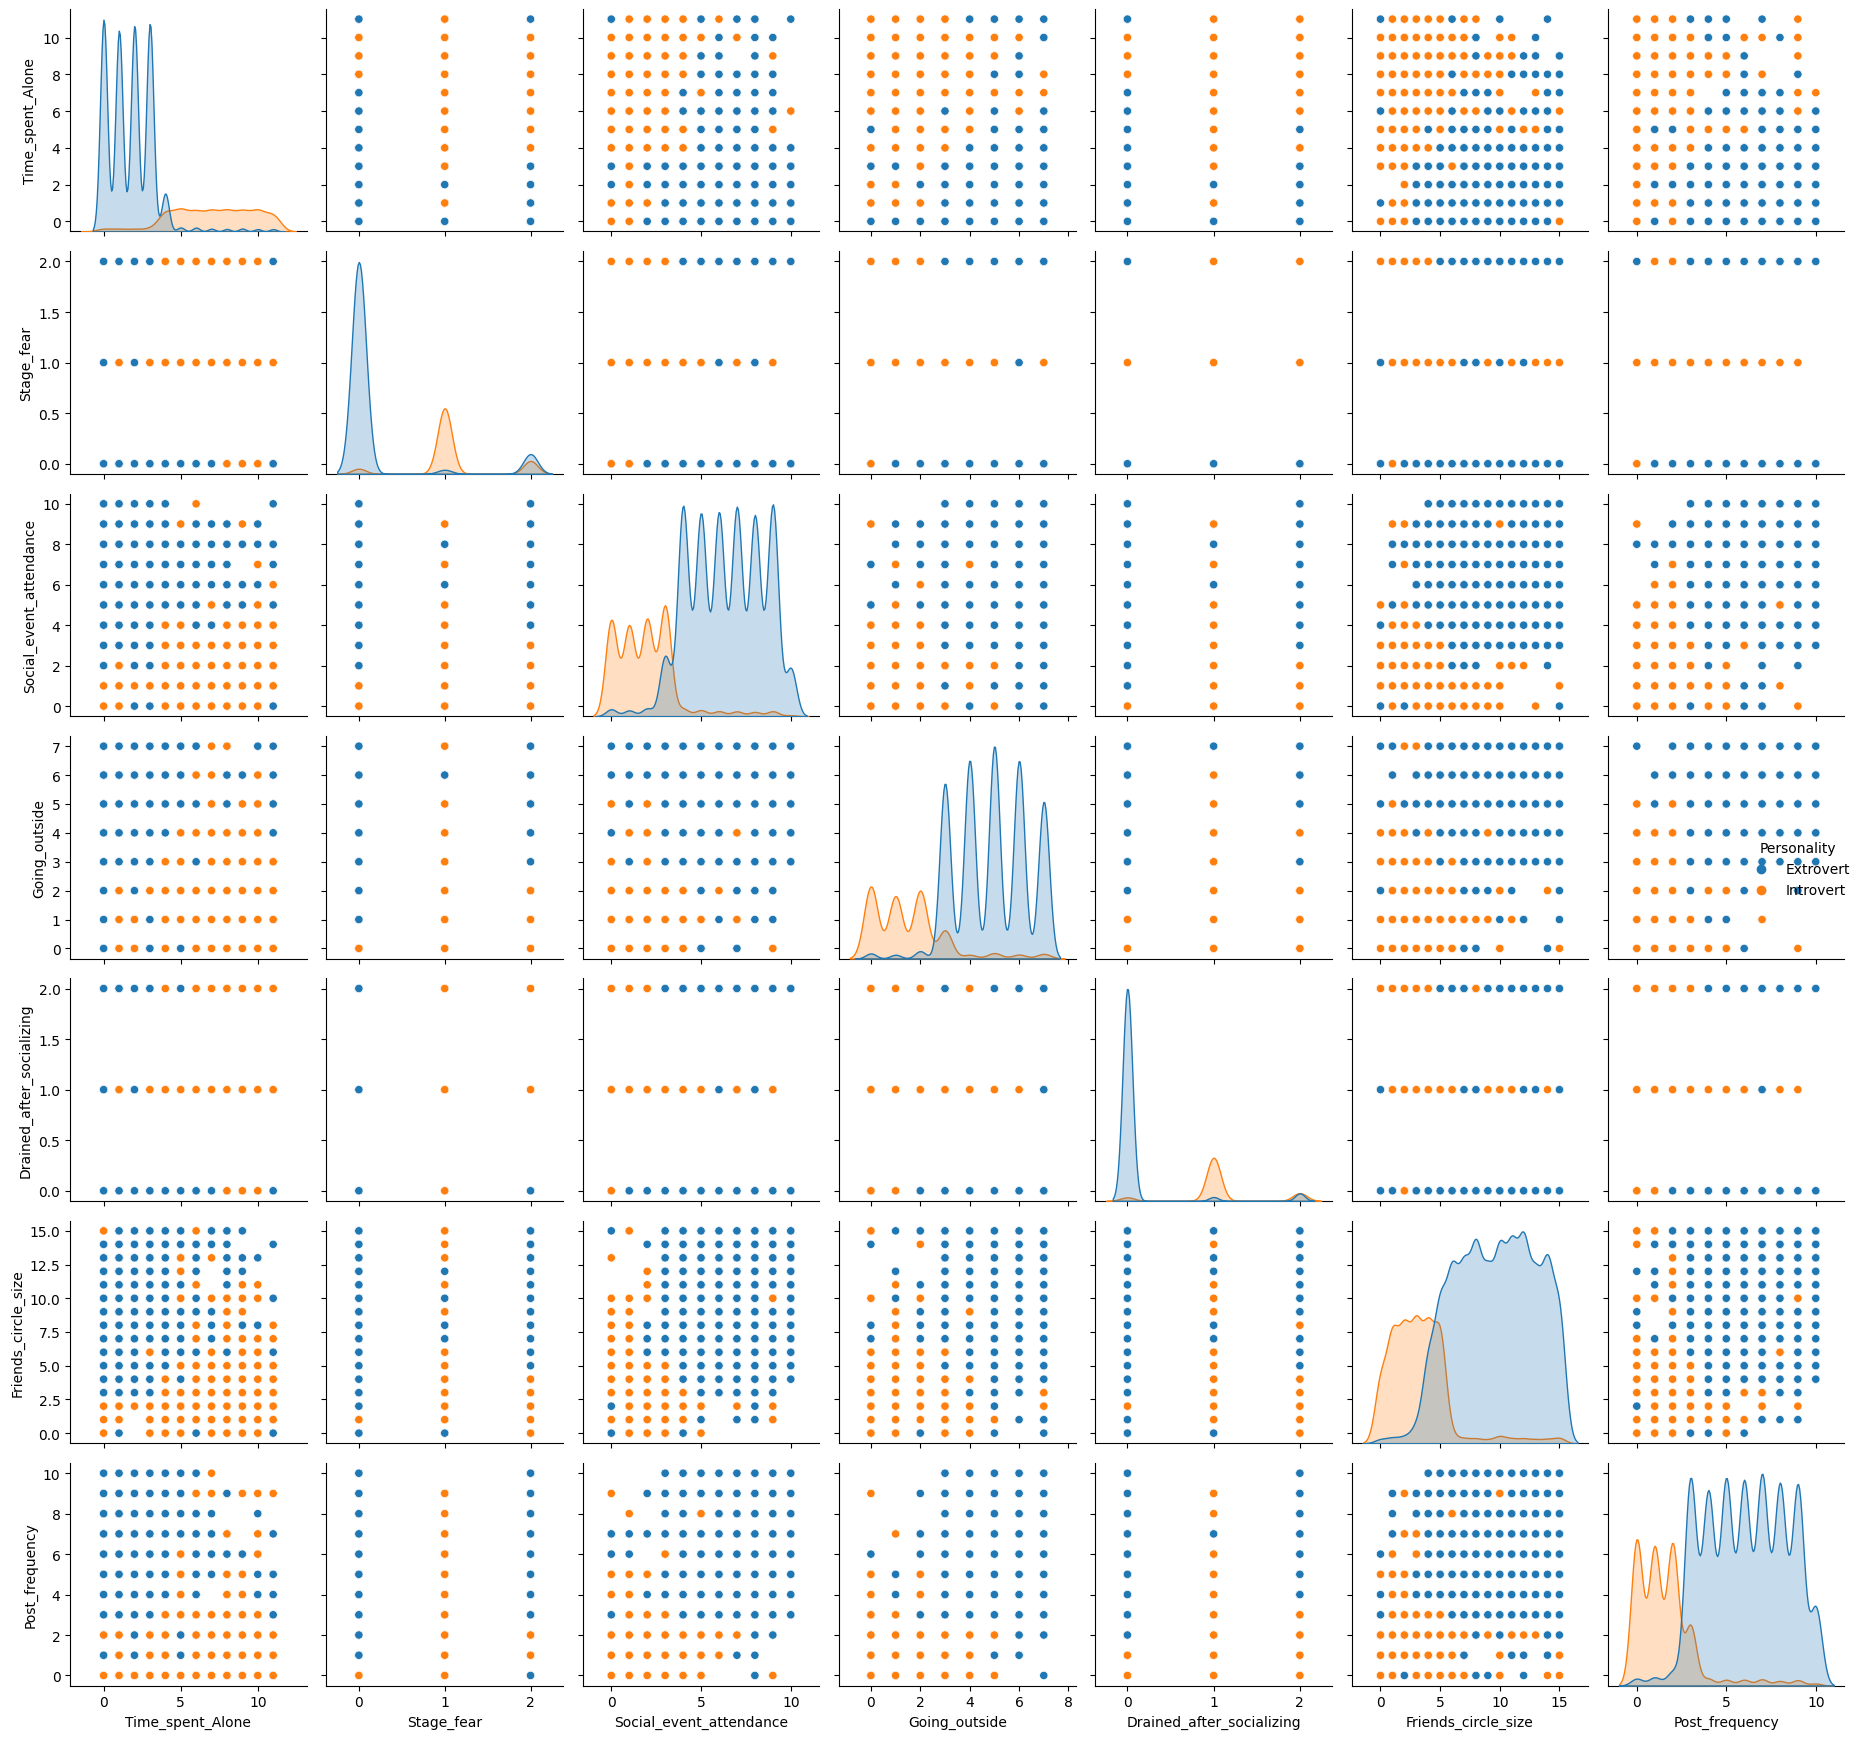

In [15]:
plt.figure(figsize=(14,4))
sns.pairplot(df_train.drop('Personality_encoded', axis=1), hue="Personality")
plt.tight_layout()
plt.show()

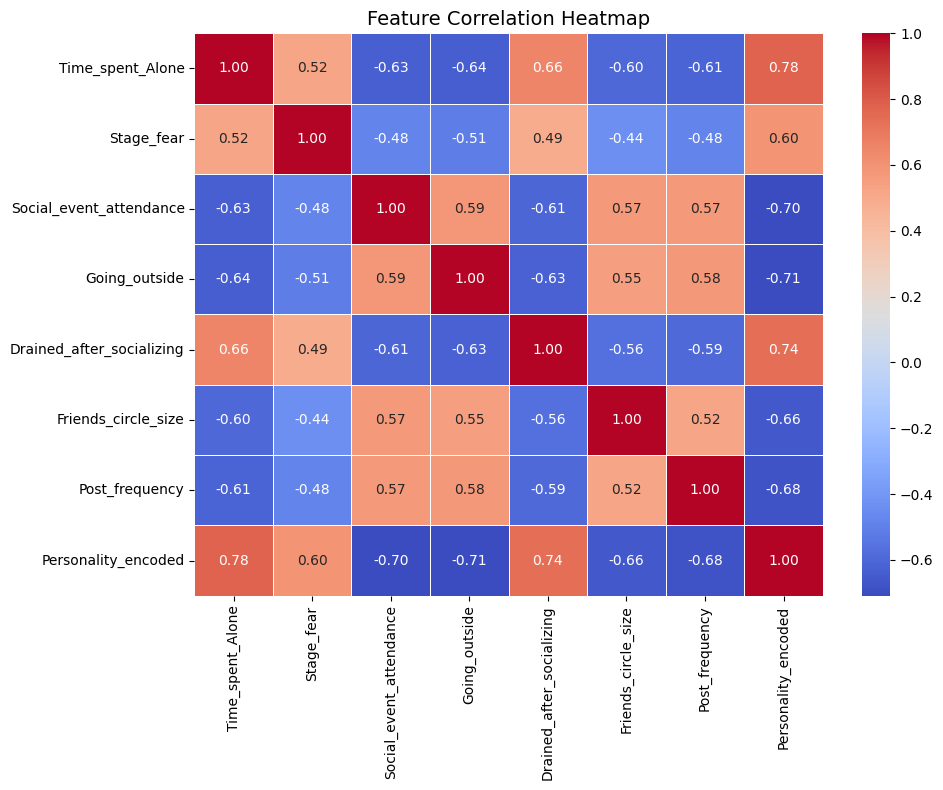

In [16]:
corr_matrix = df_train.drop(labels=['Personality'], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## Handling Missing Values

### Fill NaN Values on Numerical Columns

In [17]:
imputer = IterativeImputer(random_state=42)
df_train[num_cols] = imputer.fit_transform(df_train[num_cols])
df_test[num_cols] = imputer.transform(df_test[num_cols])

### Fill NaN Values on Categorical Columns

In [18]:
cat_cols = ['Stage_fear', 'Drained_after_socializing']

modus_cat = {}

for col in cat_cols:
    modus_value = df_train[col].mode().iloc[0]
    df_train[col] = df_train[col].fillna(modus_value)
    df_test[col] = df_test[col].fillna(modus_value)

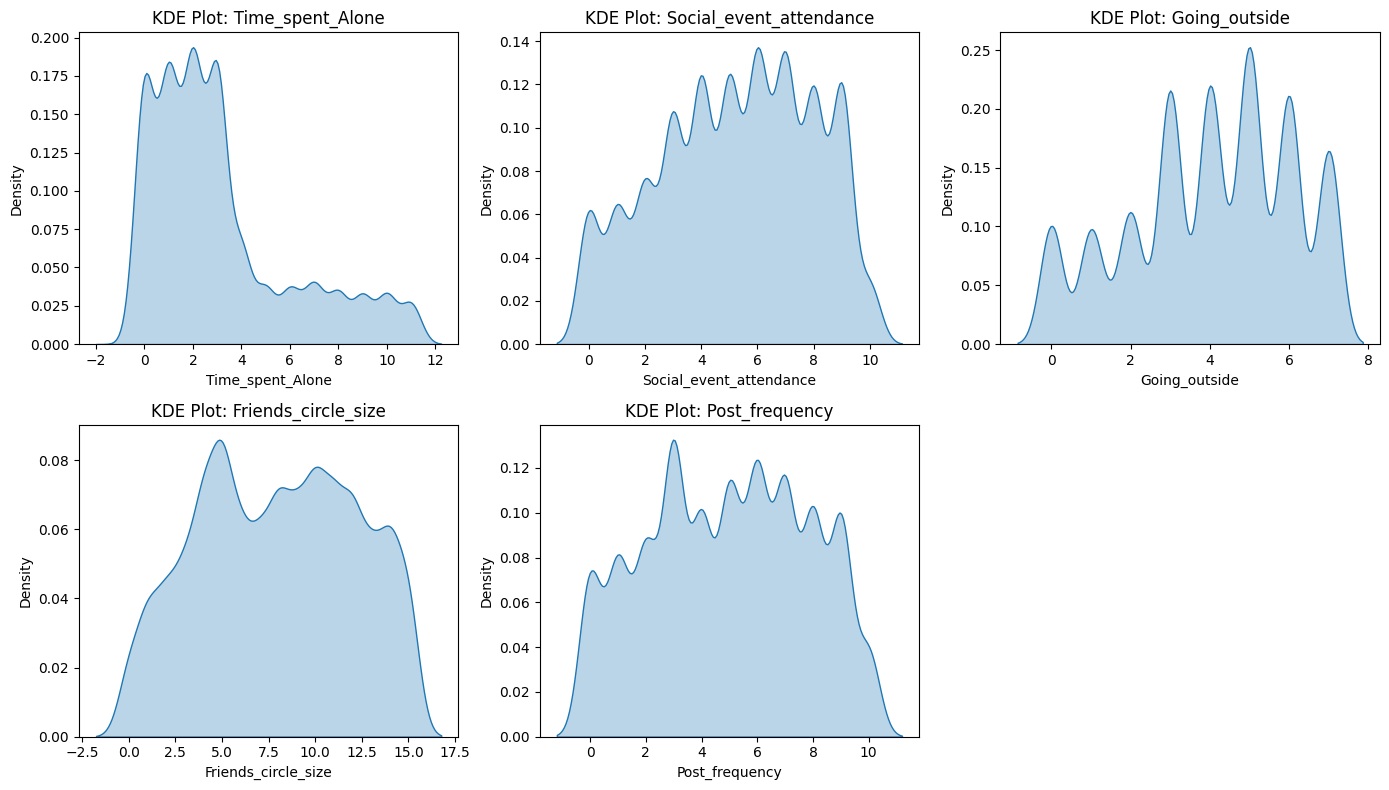

In [19]:
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(
        df_train[col].dropna(),
        ax=axes[i],
        fill=True,
        alpha=0.3
    )
    axes[i].set_title(f'KDE Plot: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Fix Skewness

In [20]:
df_train.drop(labels=['Personality'], axis=1).skew()

Time_spent_Alone             1.137185
Stage_fear                   1.309688
Social_event_attendance     -0.222018
Going_outside               -0.359937
Drained_after_socializing    1.524721
Friends_circle_size         -0.053831
Post_frequency              -0.052862
Personality_encoded          1.091595
dtype: float64

In [21]:
cols = ['Stage_fear', 'Time_spent_Alone', 'Drained_after_socializing']

boxcox_lambdas = {}

for col in cols:
    df_train[col], fitted_lambda = boxcox(df_train[col] + 1)
    boxcox_lambdas[col] = fitted_lambda

for col in cols:
    df_test[col] = boxcox(df_test[col] + 1, lmbda=boxcox_lambdas[col])

In [22]:
df_train.drop(labels=['Personality'], axis=1).skew()

Time_spent_Alone            -0.009271
Stage_fear                   0.787170
Social_event_attendance     -0.222018
Going_outside               -0.359937
Drained_after_socializing    0.975921
Friends_circle_size         -0.053831
Post_frequency              -0.052862
Personality_encoded          1.091595
dtype: float64

<Figure size 1400x400 with 0 Axes>

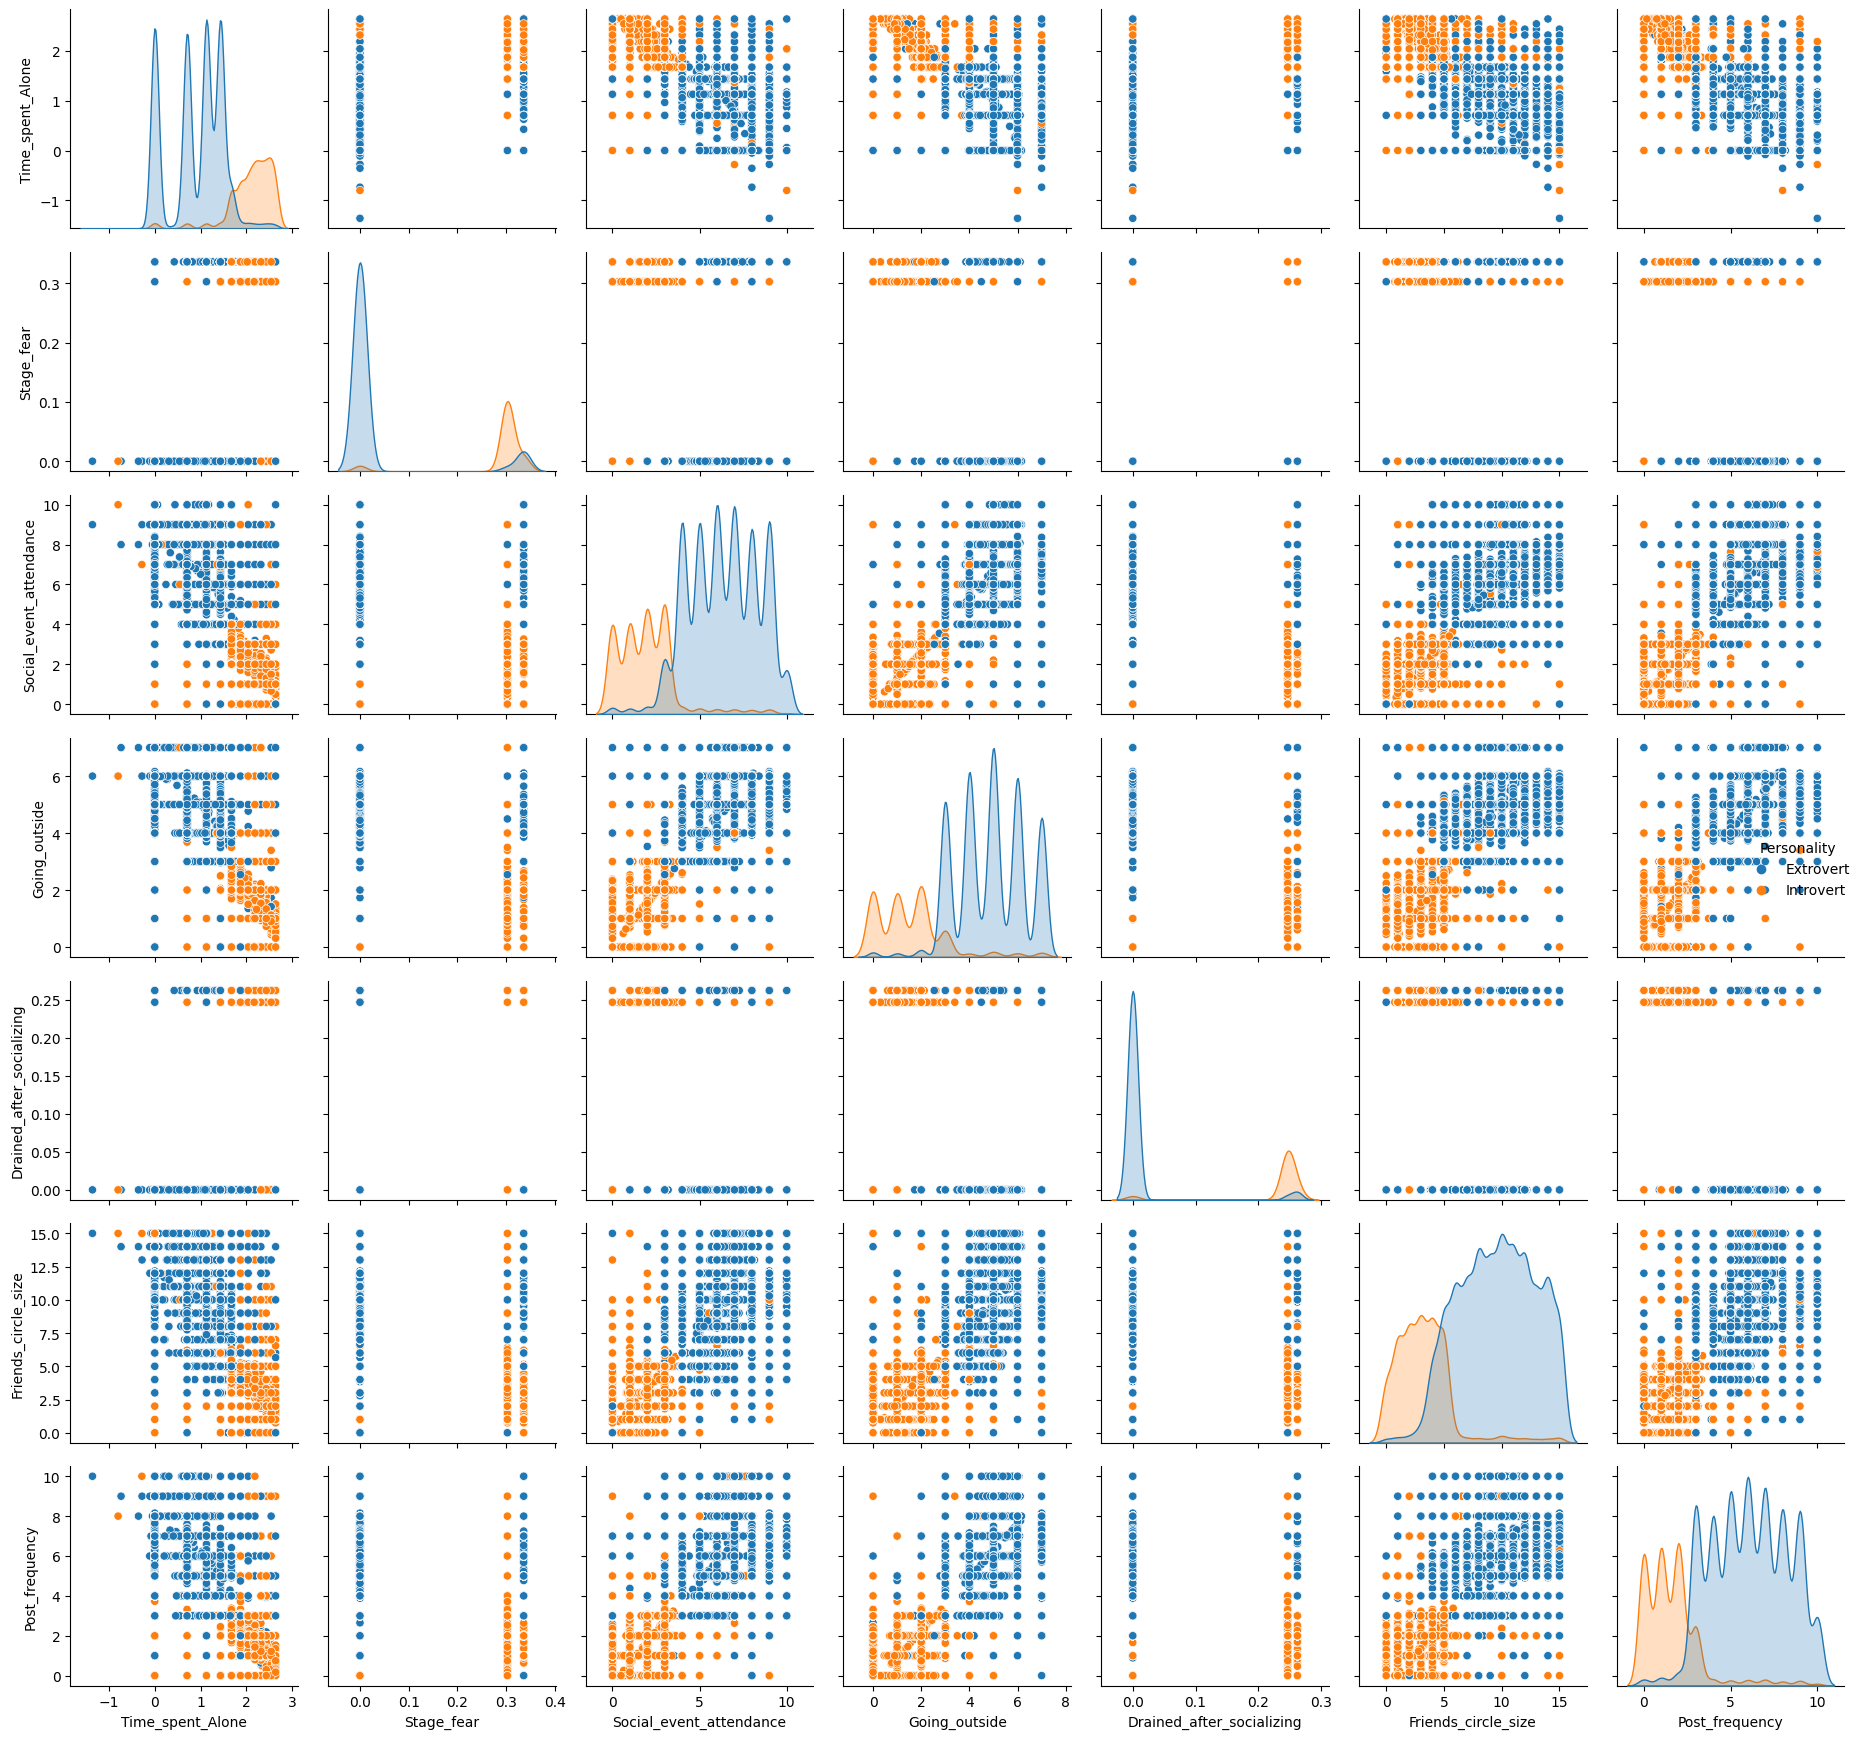

In [23]:
plt.figure(figsize=(14,4))
sns.pairplot(df_train.drop('Personality_encoded', axis=1), hue="Personality")
plt.tight_layout()
plt.show()

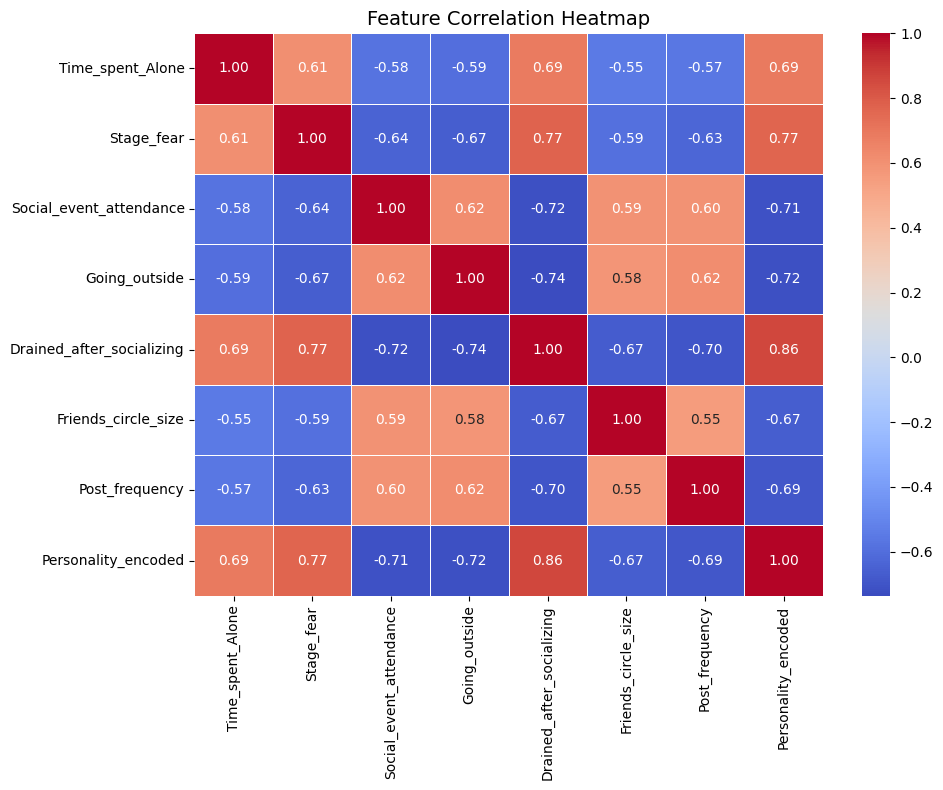

In [24]:
corr_matrix = df_train.drop(labels=['Personality'], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# 4. Train

In [25]:
features = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
    'Post_frequency'
]
X = df_train[features]
y = df_train['Personality_encoded']

In [26]:
# create adaboost objective for hyperparameter tunning
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)

    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

    return np.mean(scores)

In [27]:
# create catboost objective for hyperparameter tuning (CPU only)
def objective_catboost(trial):
    depth = trial.suggest_int('depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)
    iterations = trial.suggest_int('iterations', 100, 1000)

    model = cb.CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        verbose=0,
        random_state=42
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

    return np.mean(scores)

In [28]:
# create lightgbm objective for hyperparameter tuning (CPU only)
def objective_lightgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 20, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)

    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        verbosity=-1,
        random_state=42
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

    return np.mean(scores)

In [29]:
# create randomforest objective for hyperparameter tunning
def objective_randomforest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return np.mean(scores)

In [30]:
# create XGBoost objective for hyperparameter tuning (CPU only)
def objective_xgboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='mlogloss',
        verbosity=0,
        random_state=42
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

    return np.mean(scores)

In [31]:
# run optuna hyperparameter tunning
# tuning AdaBoost
study_adb = optuna.create_study(direction='maximize')
study_adb.optimize(objective_adaboost, n_trials=30)
best_params_adb = study_adb.best_params

# tuning CatBoost
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_catboost, n_trials=30)
best_params_cb = study_cb.best_params

# tuning LightGBM
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lightgbm, n_trials=30)
best_params_lgb = study_lgb.best_params

# tuning RandomForest
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_randomforest, n_trials=30)
best_params_rf = study_rf.best_params

# tuning XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgboost, n_trials=30)
best_params_xgb = study_xgb.best_params

[I 2025-07-03 11:27:18,152] A new study created in memory with name: no-name-12f89a43-4192-427e-988b-261504eb4df0
[I 2025-07-03 11:27:31,814] Trial 0 finished with value: 0.9684734743487727 and parameters: {'n_estimators': 485, 'learning_rate': 0.8772623969633444}. Best is trial 0 with value: 0.9684734743487727.
[I 2025-07-03 11:27:33,843] Trial 1 finished with value: 0.9689053523491399 and parameters: {'n_estimators': 89, 'learning_rate': 0.03287029279219808}. Best is trial 1 with value: 0.9689053523491399.
[I 2025-07-03 11:27:43,709] Trial 2 finished with value: 0.9684194932421601 and parameters: {'n_estimators': 443, 'learning_rate': 0.5246491740958846}. Best is trial 1 with value: 0.9689053523491399.
[I 2025-07-03 11:27:50,385] Trial 3 finished with value: 0.9684194932421601 and parameters: {'n_estimators': 306, 'learning_rate': 0.4085959272931344}. Best is trial 1 with value: 0.9689053523491399.
[I 2025-07-03 11:27:55,083] Trial 4 finished with value: 0.9684734743487727 and parame

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 7
[LightGBM] [Info] [bin

[I 2025-07-03 11:41:05,605] Trial 9 finished with value: 0.9648025987880484 and parameters: {'num_leaves': 33, 'learning_rate': 0.29274996642595863, 'n_estimators': 159}. Best is trial 5 with value: 0.9686894133489563.
[I 2025-07-03 11:41:08,531] Trial 10 finished with value: 0.9679876443892586 and parameters: {'num_leaves': 54, 'learning_rate': 0.014855086239702657, 'n_estimators': 54}. Best is trial 5 with value: 0.9686894133489563.


[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[Light

[I 2025-07-03 11:41:09,543] Trial 11 finished with value: 0.9668539974291935 and parameters: {'num_leaves': 54, 'learning_rate': 0.011770394622864777, 'n_estimators': 52}. Best is trial 5 with value: 0.9686894133489563.


[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [bin

[I 2025-07-03 11:41:13,709] Trial 12 finished with value: 0.9677177534299279 and parameters: {'num_leaves': 47, 'learning_rate': 0.09437513046043627, 'n_estimators': 243}. Best is trial 5 with value: 0.9686894133489563.
[I 2025-07-03 11:41:14,998] Trial 13 finished with value: 0.9686894424964221 and parameters: {'num_leaves': 69, 'learning_rate': 0.07775093469576516, 'n_estimators': 51}. Best is trial 13 with value: 0.9686894424964221.


[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [bin

[I 2025-07-03 11:41:21,408] Trial 14 finished with value: 0.9643166668124039 and parameters: {'num_leaves': 71, 'learning_rate': 0.11539728346948502, 'n_estimators': 301}. Best is trial 13 with value: 0.9686894424964221.
[I 2025-07-03 11:41:26,884] Trial 15 finished with value: 0.9633449923196429 and parameters: {'num_leaves': 100, 'learning_rate': 0.20052285658202124, 'n_estimators': 184}. Best is trial 13 with value: 0.9686894424964221.
[I 2025-07-03 11:41:29,449] Trial 16 finished with value: 0.9688513858162601 and parameters: {'num_leaves': 67, 'learning_rate': 0.06164772332030234, 'n_estimators': 106}. Best is trial 16 with value: 0.9688513858162601.
[I 2025-07-03 11:41:31,564] Trial 17 finished with value: 0.9685274700291184 and parameters: {'num_leaves': 67, 'learning_rate': 0.04830199567119921, 'n_estimators': 108}. Best is trial 16 with value: 0.9688513858162601.
[I 2025-07-03 11:41:37,290] Trial 18 finished with value: 0.9629131288930084 and parameters: {'num_leaves': 64, 'le


[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1

[I 2025-07-03 11:42:07,337] Trial 22 finished with value: 0.9685814365619979 and parameters: {'num_leaves': 77, 'learning_rate': 0.06909332201032793, 'n_estimators': 96}. Best is trial 16 with value: 0.9688513858162601.



[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3860, number of negative: 10960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260459 -> initscore=-1.043585
[LightGBM] [Info] Start training from score -1.043585
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:Boost

[I 2025-07-03 11:42:12,022] Trial 23 finished with value: 0.9671238446673254 and parameters: {'num_leaves': 75, 'learning_rate': 0.10921888122797219, 'n_estimators': 158}. Best is trial 16 with value: 0.9688513858162601.
[I 2025-07-03 11:42:13,005] Trial 24 finished with value: 0.9683654829880816 and parameters: {'num_leaves': 58, 'learning_rate': 0.03756432022786578, 'n_estimators': 50}. Best is trial 16 with value: 0.9688513858162601.
[I 2025-07-03 11:44:07,169] Trial 12 finished with value: 0.9691212330543921 and parameters: {'n_estimators': 460, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.9691212330543921.
[I 2025-07-03 11:44:17,361] Trial 13 finished with value: 0.9690672373740465 and parameters: {'n_estimators': 427, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 4 with value: 0.9691212330543921.
[I 2025-07-03 11:44:28,006] Trial 14 finished with va

In [32]:
# get a stacking ensemble of models
def get_stacking():
    level0 = list()
    level0.append(('rf', RandomForestClassifier(**best_params_rf, random_state=42)))
    level0.append(('adb', AdaBoostClassifier(**best_params_adb, random_state=42)))
    level0.append(('cb', cb.CatBoostClassifier(**best_params_cb, verbose=0, random_state=42))) 
    level0.append(('lgb', lgb.LGBMClassifier(**best_params_lgb, verbose=-1, random_state=42))) 
    level0.append(('xgb', xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42))) 

    level1 = LogisticRegression(random_state=42)
    stacked_model = StackingClassifier(
        estimators=level0,
        final_estimator=level1,
        cv=5
    )
    return stacked_model



# get list of models to evaluate
def get_models():
    models = dict()
    models['rf'] = RandomForestClassifier(**best_params_rf, random_state=42)
    models['adb'] = AdaBoostClassifier(**best_params_adb, random_state=42)
    models['cb'] = cb.CatBoostClassifier(**best_params_cb, verbose=0, random_state=42) 
    models['lgb'] = lgb.LGBMClassifier(**best_params_lgb, verbose=-1, random_state=42)  
    models['xgb'] = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)  
    models['stacking'] = get_stacking()
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores

>rf 0.969 (0.003)
>adb 0.969 (0.003)
>cb 0.969 (0.003)
>lgb 0.969 (0.003)
>xgb 0.969 (0.003)
>stacking 0.969 (0.003)


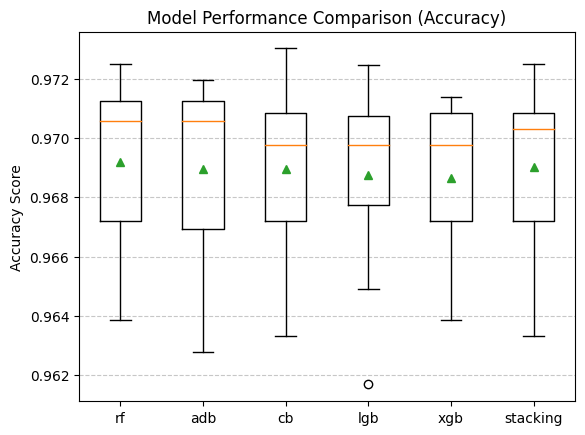

In [33]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Performance Comparison (Accuracy)') # Added a title
plt.ylabel('Accuracy Score') # Added y-label
plt.grid(axis='y', linestyle='--', alpha=0.7) # Added grid
plt.show()

In [34]:
stacking_model = get_stacking()
stacking_model.fit(X, y)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=23,
                                                       max_features='log2',
                                                       min_samples_leaf=7,
                                                       min_samples_split=17,
                                                       n_estimators=378,
                                                       random_state=42)),
                               ('adb',
                                AdaBoostClassifier(learning_rate=0.015760417800298583,
                                                   n_estimators=99,
                                                   random_state=42)),
                               ('cb',
                                <catboost.core.CatBoostClassifier object at 0x7de8d428fc50>),
                               ('lgb',
                                LGBMClassif...
                                              interaction_constraints=None,
                                              learning_rate=0.12784336838258709,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=488, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(random_state=42))

# 5. Submission

In [35]:
X_test = df_test[features]

In [36]:
test_preds_encoded = stacking_model.predict(X_test)

test_preds_label = le_encoder.inverse_transform(test_preds_encoded)

In [37]:
df_submission = df_sample_submission.copy()
df_submission['Personality'] = test_preds_label

df_submission.to_csv('submission.csv', index=False)
print('Submission saved!')

Submission saved!
